In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import poligrain as plg

In [63]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) #suppress warnings in functions or not?

## Preparing the data sets

So far this notebook only covers the comparison between CML and radar. <br>
*To be added later: allow for cross validation with a third (point based) sensor*

### Load CML and radar data
Following the example from [`Get_grid_at_lines_and_points.ipynb`](https://github.com/OpenSenseAction/poligrain/blob/main/docs/notebooks/Get_grid_at_lines_and_points.ipynb), we use CML data that has already been processed to include path-averaged rainfall rate (see how that is done [here](https://github.com/OpenSenseAction/merging_prototype/blob/9cd018be263a8f5ae38bb28c1f768b353d97ffbc/radar_cml_gauge_merge_prototype.ipynb)).  

In [14]:
# Load datasets
ds_cmls = xr.open_dataset("data/openMRG_cmls_20150827_12hours.nc")
ds_radar = xr.open_dataset("data/openMRG_example_rad_20150827_90minutes.nc")

### Resample CML data

The radar data is in 5 minute intervals, and the CML data in 1 minute intervals, so we resample the CML data to 5 minutes. <br>
*Double check: Was the original 10s CML data resampled using the left or right timestamp as handle? I assume the right.* 

Both CML and radar rainfall rate are already in mm/hr, so need to do any transformation here. 

In [15]:
ds_cmls_5m = ds_cmls.R.resample(time="5min", label="right").mean()

### Get one radar value for each CML value
We want to compare the radar estimates along the line with the CML based rainfall estimates on a point to point basis. We therefore need to make sure that use the same time period. 

After that we need to make sure that for each sub-link, there is a radar rainfall estimate to compare to. I.e. two CML rainfall estimates per single radar estimate. Note that these should be much different since they cover the same path, but at slighlty different frequencies. 

For this data set each sublink item has shape cml_id\*time (364\*19) whereas the radar\_along\_cml data has shape (19\*364), so we transpose the radar data.


In [16]:
get_grid_at_lines = plg.spatial.GridAtLines(
    da_gridded_data=ds_radar,
    ds_line_data=ds_cmls_5m,
)

In [17]:
radar_along_cml = get_grid_at_lines(da_gridded_data=ds_radar.rainfall)

ds_cmls_5m = ds_cmls_5m.where(ds_cmls_5m.time.isin(radar_along_cml.time), drop=True)

sublink_0 = ds_cmls_5m.isel(sublink_id=0)
sublink_1 = ds_cmls_5m.isel(sublink_id=1)

cmls_flattened = np.concatenate(
    [sublink_0.values.flatten(), sublink_1.values.flatten()]
)
radar_flattened = np.tile(radar_along_cml.values.T.flatten(), 2)

Set a threshold. 


In [20]:
threshold = 0.0  # mm/h

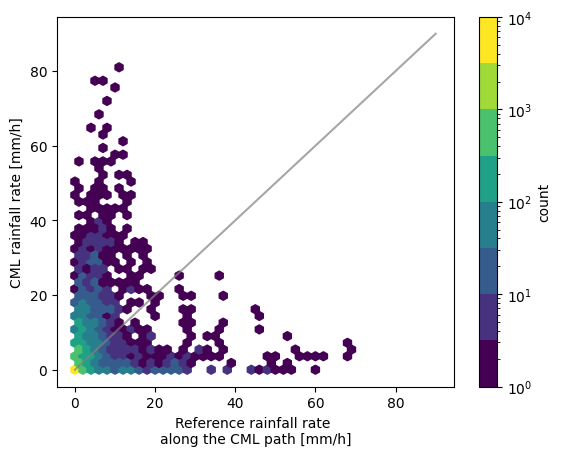

In [36]:
fig, ax = plt.subplots()
hx = plg.validation.plot_hexbin(
    radar_flattened,
    cmls_flattened,
    ref_thr=threshold,
    pred_thr=threshold,
    ax=ax,)


In [37]:
fig, ax = plt.subplots()
hx = plg.validation.plot_hexbin(
    radar_flattened,
    cmls_flattened,
    ref_thr=threshold,
    pred_thr=threshold,
    ax=ax,)

ax.set_ylabel("Different y_label")

# change colormap and label
hx.set_cmap('Blues')
hx.colorbar.set_label("Different colorbar label")

In [ ]:
# thresh_idx = (
#     (radar_flattened >= threshold) | (cmls_flattened >= threshold)
# )

# fig, ax = plt.subplots(figsize=(6, 5))
# hx = ax.hexbin(
#     radar_flattened[~thresh_idx],
#     cmls_flattened[~thresh_idx],
#     mincnt=1,
#     bins="log",
#     gridsize=45,
#     extent=(0, 100, 0, 100),
# )
# ax.plot([0, 100], [0, 100], color="gray", alpha=0.7)
# ax.set_xlabel("Average 5-minute radar rainfall rate \nalong the CML path [mm/h]")
# ax.set_ylabel("5-minute CML rainfall rate [mm/h]")

# # make nice looking colorbar to avoid arbitrary coloring
# oom = int(np.ceil(np.log10(hx.get_clim()[1])))
# hx.set_clim([1, 10**oom])
# hx.set_cmap(plt.get_cmap("viridis", oom * 2))  # 2 colors per order of magnitude
# cbar = plt.colorbar(hx, ax=ax)
# cbar.set_label("count")

## Calculate validation metrics
[Tbd] In the function include an assert statement to check for similar shape as in [pycomlink](https://github.com/pycomlink/pycomlink/blob/master/pycomlink/validation/stats.py)


In [38]:
# applying the threshold - ideally this should match what is being plotted, so by default the threshold is taken into account
thresh_idx = (radar_flattened >= threshold) | (cmls_flattened >= threshold)

radar_flattened = radar_flattened[thresh_idx]
cmls_flattened = cmls_flattened[thresh_idx]

In [62]:
rainfall_metrics = plg.validation.calculate_rainfall_metrics(reference=radar_flattened, 
                                          predicted=cmls_flattened,
                                          ref_thr=threshold,
                                          pred_thr=threshold)

C:\Users\baswalraven\OneDrive - Delft University of Technology\Documents\OpenSense\WG2\poligrain\src\poligrain\validation.py:180: RuntimeWarning: invalid value encountered in divide
  false_wet_rate = N_false_wet / float(N_dry)
C:\Users\baswalraven\OneDrive - Delft University of Technology\Documents\OpenSense\WG2\poligrain\src\poligrain\validation.py:194: RuntimeWarning: Mean of empty slice.
  
C:\Users\baswalraven\OneDrive - Delft University of Technology\Documents\OpenSense\WG2\poligrain\src\poligrain\validation.py:195: RuntimeWarning: Mean of empty slice.
  return {


In [65]:
wet_dry_metrics = plg.validation.calculate_wet_dry_metrics(reference=radar_flattened, 
                                                           predicted=cmls_flattened)

In [66]:
wet_dry_metrics

{'matthews_correlation_coefficient': nan,
 'true_wet_rate': nan,
 'true_dry_rate': nan,
 'false_wet_rate': nan,
 'missed_wet_rate': nan,
 'N_dry_reference': 0,
 'N_wet_reference': 0,
 'N_true_wet': 0,
 'N_true_dry': 0,
 'N_false_wet': 0,
 'N_missed_wet': 0}

In [58]:
# filtering out the NaNs
nan_idx = np.isnan(radar_flattened) | np.isnan(cmls_flattened)

N_all = len(radar_flattened)
N_nan = np.sum(nan_idx)
N_nan_ref = np.sum(np.isnan(radar_flattened))
N_nan_pred = np.sum(np.isnan(cmls_flattened))

reference = radar_flattened[~nan_idx]
predicted = cmls_flattened[~nan_idx]

# calculating verification metrics: r, CV, RMSE, MBE
pearson_correlation = np.corrcoef(reference, predicted)
coefficient_of_variation = np.std(predicted - reference) / np.mean(reference)
root_mean_square_error = np.sqrt(np.mean((predicted - reference) ** 2))
mean_bias_error = np.mean(predicted - reference)

#
R_mean_reference = reference.mean()
R_mean_predicted = predicted.mean()

reference_wet = reference >= threshold
reference_dry = ~ reference_wet
predicted_wet = predicted >= threshold
predicted_dry = ~predicted_wet

N_false_wet = (reference_dry & predicted_wet).sum()
N_dry = reference_dry.sum()
false_wet_rate = N_false_wet / N_dry

false_wet_precipitation_rate = predicted[reference_dry & predicted_wet].mean()
false_wet_precipitation_rate = np.nan_to_num(
    false_wet_precipitation_rate
)  # to avoid NaNs in the table. Do we keep this in the function?
false_dry_precipitation_rate = np.nanmean(reference[reference_wet & predicted_dry])
false_dry_precipitation_rate = np.nan_to_num(false_dry_precipitation_rate)

C:\Users\baswalraven\AppData\Local\Temp\ipykernel_24500\3327813944.py:29: RuntimeWarning: invalid value encountered in scalar divide
  false_wet_rate = N_false_wet / N_dry
C:\Users\baswalraven\AppData\Local\Temp\ipykernel_24500\3327813944.py:31: RuntimeWarning: Mean of empty slice.
  false_wet_precipitation_rate = predicted[reference_dry & predicted_wet].mean()
c:\Users\baswalraven\Miniconda3\envs\poetry_env\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\baswalraven\AppData\Local\Temp\ipykernel_24500\3327813944.py:35: RuntimeWarning: Mean of empty slice
  false_dry_precipitation_rate = np.nanmean(reference[reference_wet & predicted_dry])


## Print pretty table with verification metrics
- *In the function perhaps remove the units incase users compare mm. Optionally ask the user to input units.* 

In [ ]:
# Print pretty table with verification metrics

print("Verification metrics")
print("--------------------")
print("")
print(f"Rainfall rate threshold:                {threshold} mm/h")
print(
    f"Pearson correlation coefficient:        {np.round(pearson_correlation[0, 1], 2)}"
)
print(
    f"Coefficient of variation:               {np.round(coefficient_of_variation, 2)}"
)
print(
    f"Root mean square error:                {np.round(root_mean_square_error, 2)} mm/h"
)
print(f"Mean bias error:                        {np.round(mean_bias_error, 2)} mm/h")
print("")
print(f"Reference mean rain rate:               {np.round(R_mean_reference, 2)} mm/h")
print(f"Predicted mean rain rate:               {np.round(R_mean_predicted, 2)} mm/h")
print(
    f"False wet rain rate:                    {np.round(false_wet_precipitation_rate, 2)} mm/h"
)
print(
    f"False dry rain rate:                    {np.round(false_dry_precipitation_rate, 2)} mm/h"
)
print("")
print(f"N_pairs:                                 {N_all}")
print(f"N_nan_pairs:                             {N_nan}")

### [WIP] Wet-Dry verification metrics

## Visualize wet-dry metrics
Make histograms of true positives, false positives, and false negatives, corresponding to the scatter density plot above. 

In [ ]:
ttt = np.logical_and(cmls_flattened < threshold, radar_flattened < threshold)
len(cmls_flattened[ttt])

In [59]:
threshold = 0.1  # mm/h

In [95]:
# we use mask instead of .where because the object is a numpy array and not an xarray object
tp_mask = np.logical_and(cmls_flattened >= threshold, radar_flattened >= threshold)
tp, _ = np.histogram(
    cmls_flattened[tp_mask],
    bins=np.logspace(-2, 2, num=101, endpoint=True, base=10, dtype=None, axis=0),
)

fp_mask = np.logical_and(cmls_flattened >= threshold, radar_flattened < threshold)
fp, _ = np.histogram(
    cmls_flattened[fp_mask],
    bins=np.logspace(-2, 2, num=101, endpoint=True, base=10, dtype=None, axis=0),
)

fn_mask = np.logical_and(cmls_flattened < threshold, radar_flattened >= threshold)
fn, _ = np.histogram(
    radar_flattened[fn_mask],
    bins=np.logspace(-2, 2, num=101, endpoint=True, base=10, dtype=None, axis=0),
)

In [78]:
tb = np.logspace(-2, 2, num=100, endpoint=True, base=10.0, dtype=None, axis=0)

In [ ]:
tb.__getitem__.num

In [ ]:
fig, axs = plt.subplots(
    2,
    1,
    figsize=(4, 6),
    dpi=100,
    sharex=True,
)
x = np.logspace(-2, 2, num=100, endpoint=True, base=10.0, dtype=None, axis=0)

ds_cmls_size = ds_cmls_5m.sizes.get("sublink_id") * ds_cmls_5m.sizes.get("cml_id")

axs[0].plot(
    x,
    (tp) / ds_cmls_size,
    color="C0",
    linewidth=0.5,
)
axs[0].fill_between(x, (tp) / ds_cmls_size, alpha=0.3, color="C0", label="TP")
axs[0].plot(
    x,
    (fp) / ds_cmls_size,
    color="green",
    linewidth=0.5,
)
axs[0].fill_between(x, (fp) / ds_cmls_size, alpha=0.3, color="C2", label="FP")
axs[0].plot(
    x,
    (fn) / ds_cmls_size,
    color="red",
    linewidth=0.5,
)
axs[0].fill_between(x, (fn) / ds_cmls_size, alpha=0.3, color="C3", label="FN")

axs[1].plot(
    x,
    (tp) * x / 12,
    color="C0",
    linewidth=0.5,
)
axs[1].fill_between(x, (tp) * x / 12, alpha=0.3, color="C0", label="TP")
axs[1].plot(
    x,
    (fp) * x / 12,
    color="green",
    linewidth=0.5,
)
axs[1].fill_between(
    x, (fp) * x / 12, alpha=0.3, color="green", label="FP"
)
axs[1].plot(
    x,
    (fn) * x / 12,
    color="red",
    linewidth=0.5,
)
axs[1].fill_between(x, (fn) * x / 12, alpha=0.3, color="red", label="FN")


axs[0].set_xscale("log")
axs[0].axvspan(0, threshold, alpha=0.1, color="grey", label="DRY")
axs[1].axvspan(0, threshold, alpha=0.1, color="grey")

axs[0].set_ylabel("Avg. nr. of 5-min time intervals \nper sublink [-]")
# axs[0].set_xlabel('Rainfall Rate [mm/h]')
axs[1].set_ylabel("Rainfall Amount [mm]")
axs[1].set_xlabel("Rainfall Rate [mm/h]")

axs[0].legend()
plt.tight_layout()
plt.show()

In [ ]:
tp

In [91]:
# we use mask instead of .where because the object is a numpy array and not an xarray object
tp_mask = np.logical_and(cmls_flattened >= threshold, radar_flattened >= threshold)
tp, _ = np.histogram(
    cmls_flattened[tp_mask],
    bins=np.linspace(0.01, 100, 101)
)

fp_mask = np.logical_and(cmls_flattened >= threshold, radar_flattened < threshold)
fp, _ = np.histogram(
    cmls_flattened[fp_mask],
    bins=np.linspace(0.01, 100, 101)
)

fn_mask = np.logical_and(cmls_flattened < threshold, radar_flattened >= threshold)
fn, _ = np.histogram(
    radar_flattened[fn_mask],
    bins=np.linspace(0.01, 100, 101)
)

In [ ]:
fig, axs = plt.subplots(
    2,
    1,
    figsize=(4, 6),
    dpi=100,
    sharex=True,
)
x = np.linspace(0.01, 100, 100)

ds_cmls_size = ds_cmls_5m.sizes.get("sublink_id") * ds_cmls_5m.sizes.get("cml_id")

t = axs[0].plot(
    x,
    (tp) / ds_cmls_size,
    color="C0",
    linewidth=0.5,
)
tt = axs[0].fill_between(x, (tp) / ds_cmls_size, alpha=0.3, color="C0", label="TP")
axs[0].plot(
    x,
    (fp) / ds_cmls_size,
    color="green",
    linewidth=0.5,
)
axs[0].fill_between(x, (fp) / ds_cmls_size, alpha=0.3, color="green", label="FP")
axs[0].plot(
    x,
    (fn) / ds_cmls_size,
    color="red",
    linewidth=0.5,
)
axs[0].fill_between(x, (fn) / ds_cmls_size, alpha=0.3, color="red", label="FN")

axs[1].plot(
    x,
    (tp) * x / 12,
    color="C0",
    linewidth=0.5,
)
axs[1].fill_between(x, (tp) * x / 12, alpha=0.3, color="C0", label="TP")
axs[1].plot(
    x,
    (fp) * x / 12,
    color="green",
    linewidth=0.5,
)
axs[1].fill_between(
    x, (fp) * x / 12, alpha=0.3, color="green", label="FP"
)
axs[1].plot(
    x,
    (fn) * x / 12,
    color="red",
    linewidth=0.5,
)
axs[1].fill_between(x, (fn) * x / 12, alpha=0.3, color="red", label="FN")


axs[0].set_xscale("log")
axs[0].axvspan(0, threshold, alpha=0.1, color="grey", label="DRY")
axs[1].axvspan(0, threshold, alpha=0.1, color="grey")


axs[0].set_ylabel("Avg. nr. of 5-min time intervals \nper sublink [-]")
# axs[0].set_xlabel('Rainfall Rate [mm/h]')
axs[1].set_ylabel("Rainfall Amount [mm]")
axs[1].set_xlabel("Rainfall Rate [mm/h]")

axs[0].legend()
plt.tight_layout()
plt.show()

In [ ]:
t[0]

In [ ]:
tp-tr